Clustering process for ifood-data-business-analyst-test-latam-main

By: Alejandro Rojas Benítez
https://www.linkedin.com/in/arojasb3/

this module works with the standard anaconda package except kmodes

It will need the command pip install kmodes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kmodes.kprototypes import KPrototypes
from copy import deepcopy
warnings.filterwarnings('ignore')
%matplotlib inline

### Lowering dimensions
We will create 2 new datasets with lowered dimensions for an easier visualization of the clusters. For this process we will proceed with the well known Principal Component Analysis (PCA) and use t-distributed Stochastic Neighbor Embedding (tSNE).

Since clustering algorithms have some problems handling binary variables, we will only lower the dimension of the numerical variables and apply the algorithms over them. At the end we should be able to see the characteristics of each cluster regarding their: 

- Education
- Marital Status
- Compliance
- All 6 campaings

In [2]:
df2 = pd.read_csv('not_scaled_data.csv')
df_scaled = pd.read_csv('scaled_data.csv')

In [3]:
# numerical variables we will take into account
numerical_cols = [ 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
                 'age', 'enrollment_time']

# categorical variables we will take into account. We will ignore Complain since it is too unbalanced
categorical_cols = ['Education', 'Marital_Status']

# campaigns for cluster analysis
campaings = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

In [4]:
# plotting parameters
figsize = (12,8)

In [5]:
# tsne and PCA Parameters
random_state = 42

n_components = 2

In [6]:
# tsne
tsne = TSNE(n_components=n_components, random_state=random_state).fit_transform(df_scaled[numerical_cols])
df_tsne = pd.DataFrame(tsne)

In [7]:
pca = PCA(n_components=n_components)
pca.fit(df_scaled[numerical_cols])
print(pca.explained_variance_ratio_)

[0.37381523 0.1193297 ]


Now, the 2 PCA results have such a variance ratio that it may not be worth trying to plot the clusters on them, for the rest of the notebook we will work only with the tsne approach.

## Clustering
We will now start using different clustering algorithms. The first one we will try is K-Means, again a well known algorithm which involves the number of clusters. First, we will try the elbow method to find a good number of clusters in our dataset.

In my experience, more than 8 clusters start to be hard to explain and understand, so we will iterate over 1 to 8 possible groups.

### Elbow method and Silhouette Coefficient
We will try to find an optimal or acceptable number of clusters using the Elbow method and Silhouette Coefficient method. Initially using the K-Means algorithm in our numerical data, then using the K-Prototypes in both numerical and categorical data.

### K-Means

In [8]:
# elbow method parameters
lower_bound = 2
upper_bound = 8

max_iter = 1000

# silhouette metric
metric = 'euclidean'

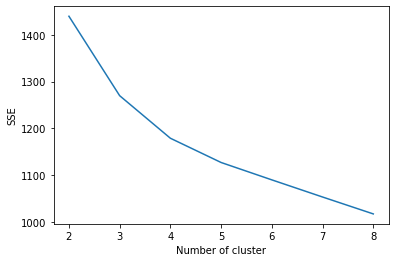

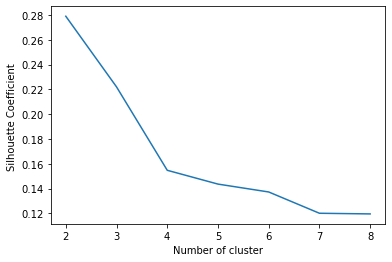

In [9]:
# with the help of https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion#:~:text=The%20idea%20behind%20elbow%20method,for%20each%20value%20of%20k.
sse = {}
sil = {}
for k in range(lower_bound, upper_bound+1):
    kmeans = KMeans(n_clusters=k, max_iter=max_iter, random_state = random_state).fit(df_scaled[numerical_cols])
    #df2["clusters"] = kmeans.labels_
    #print(data["clusters"])
    label = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    sil[k] = silhouette_score(df_scaled[numerical_cols], label, metric=metric)

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

plt.figure()
plt.plot(list(sil.keys()), list(sil.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient ")
plt.show()

For the elbow method we want to find a number of clusters where the SSE is "low" or starts to be low after that point. Even though SSE keeps going down as we add more and more clusters, the last strong change we see is at 4 clusters.

On the other hand, the Silhouette Coefficient method as stated on the sklearn documentation: relates to a model with better-defined clusters. In this case we would choose the number of clusters with the highest coeficient -> 2. Anyway, 3 and 4 clusters also have a fairly high value compared to the other numbers. 

We will try our algorithm with 4 clusters

### K-Prototypes

In [10]:
# this process was done with the help of
# https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical-and-numerical-fe7c50538ebb
catColumnsPos = [df_scaled[categorical_cols+numerical_cols].columns.get_loc(col) for col in categorical_cols]
print('Categorical columns           : {}'.format(categorical_cols))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['Education', 'Marital_Status']
Categorical columns position  : [0, 1]


In [11]:
# Elbow method on k prototypes
# since silhouette doesn't work for categorical values it wont be used here
sse_prot = {}
for cluster in range(lower_bound, upper_bound+1):
    kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = random_state, max_iter=max_iter)
    kprototype.fit_predict(df_scaled[categorical_cols+numerical_cols], categorical = catColumnsPos)
    sse_prot[cluster] = kprototype.cost_

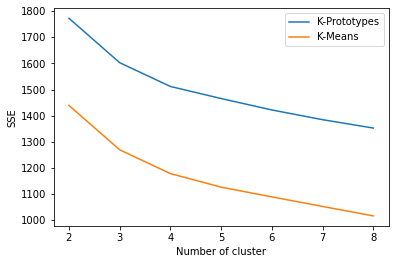

In [12]:
plt.figure()
plt.plot(list(sse_prot.keys()), list(sse_prot.values()))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.legend(['K-Prototypes', 'K-Means'])
plt.show()

Apparently K prototypes only made the SSE worse, lets stick with the 4 clusters but it was a good try.

### Actual Clustering


### K-Means

In [13]:
# Kmeans parameters
k = 4
max_iter = 1000
random_state = 42

In [14]:
kmeans = KMeans(n_clusters=k, max_iter=max_iter, random_state = random_state).fit(df_scaled[numerical_cols])
df2["clusters_kmeans"] = kmeans.labels_
df_scaled["clusters_kmeans"] = kmeans.labels_
df_tsne["clusters_kmeans"] = kmeans.labels_

Now that we created our kmeans clusters, lets plot them using our tSNE reduced dataset

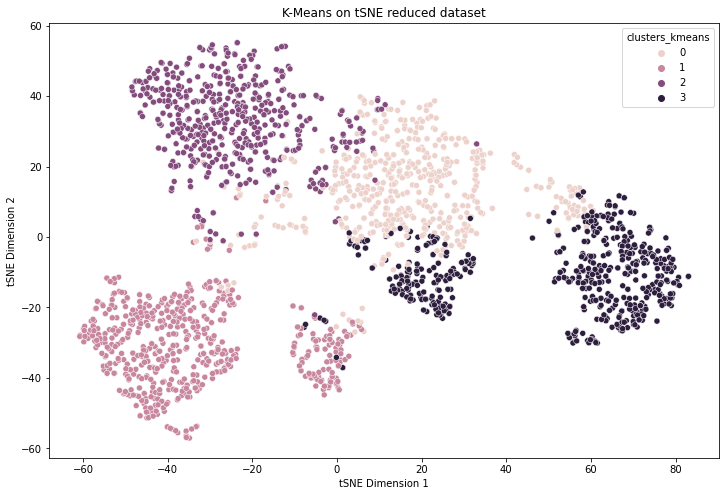

In [15]:
plt.figure(figsize=figsize);
sns_plot = sns.scatterplot(data=df_tsne, x=0, y=1, hue="clusters_kmeans")
sns_plot.set(xlabel='tSNE Dimension 1', ylabel='tSNE Dimension 2', title='K-Means on tSNE reduced dataset');

### K-Prototypes

In [16]:
# Kprototypes parameters
k = 4
max_iter = 1000
random_state = 42

In [65]:
kprototype = KPrototypes(n_jobs = -1, n_clusters = k, init = 'Huang', random_state = random_state, max_iter=max_iter)

kprototype.fit_predict(df_scaled[categorical_cols+numerical_cols], categorical = catColumnsPos)
df2["clusters_kprot"] = kprototype.labels_
df_scaled["clusters_kprot"] = kprototype.labels_
df_tsne["clusters_kprot"] = kprototype.labels_

Now that we created our kprototypes clusters, lets plot them using our tSNE reduced dataset

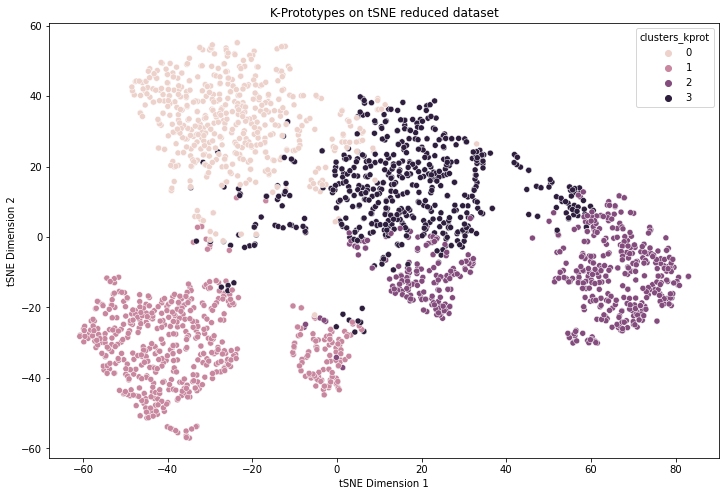

In [66]:
plt.figure(figsize=figsize);
sns_plot = sns.scatterplot(data=df_tsne, x=0, y=1, hue="clusters_kprot")
sns_plot.set(xlabel='tSNE Dimension 1', ylabel='tSNE Dimension 2', title='K-Prototypes on tSNE reduced dataset');

We now have 2 different groups of clusters but before actually trying to describe each, lets find out if the one found with K means are different from the ones from K Prototypes. To achieve this, we will just see the differences in the last campaign response for both groups.

For the moment we will just show a lot functions to make our plotting easier.

In [83]:
def get_campaign_frequency_cluster(df, group, campaings, k):
    """function that returns a Pandas Data Frame of the 
    percentage of accepted campaigns per cluster
    """
    kmeans_list = {}
    for camp in campaings: kmeans_list[camp] = []
    for clust in range(0, k):   
        for camp in campaings:
            kmeans_list[camp].append(1 - list(df[df[group] == clust][camp].value_counts())[0] / df[df[group] == clust].shape[0])
            
    return pd.DataFrame(kmeans_list, index=range(0, k))

In [179]:
def create_campaign_pie_charts(df, campaign, title):
    # thanks to help from https://stackoverflow.com/questions/62169907/seaborn-catplot-kind-count-change-bar-chart-to-pie-chart
    """function that creates a cool pie chart plot for each cluster for a campaign acceptance
    """
    fig, axes = plt.subplots(nrows=2, ncols=2)
    labels = 'Accepted', 'Rejected'
    colors = ['#008fd5', '#fc4f30']
    explode = (0.1, 0.1)

    plt.tight_layout()

    for i, col in enumerate(df.index):
        numb = df.iloc[i][campaign]
        curr = list(axes.flat)[i]
        curr.pie([numb, 1-numb], startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'}, autopct='%1.f%%', explode=explode, shadow=True)
        curr.set_title(f'Cluster {i}', fontweight='bold')

    fig.suptitle(title, fontsize=20, y=1.07, fontweight='bold', x=0.37)
    fig.set_figheight(10)
    fig.set_figwidth(7)
    fig.legend(loc='best', labels=labels, fontsize='medium')
    fig.tight_layout()

In [194]:
def create_categorical_pie_charts(df, title):
    # thanks to help from https://stackoverflow.com/questions/62169907/seaborn-catplot-kind-count-change-bar-chart-to-pie-chart
    
    """function inspired on the previous pie one, to plot the frequencies of a categorical
    variable for the clusters
    """
    fig, axes = plt.subplots(nrows=2, ncols=2)
    labels = df.columns
    #colors = ['#008fd5', '#fc4f30']

    plt.tight_layout()

    for i, col in enumerate(df.index):
        curr = list(axes.flat)[i]
        curr.pie(list(df.iloc[i]), startangle=90,  wedgeprops={'edgecolor': 'black'}, autopct='%1.f%%', pctdistance=1.2, shadow=True)
        curr.set_title(f'Cluster {i}', fontweight='bold')

    fig.suptitle(title, fontsize=20, y=1.07, fontweight='bold', x=0.37)
    fig.set_figheight(10)
    fig.set_figwidth(7)
    fig.legend(loc='best', labels=labels, fontsize='medium')
    fig.tight_layout()

In [201]:
def plot_boxes(df, cluster_col, horizontal, vertical, columns, figsize=(16,8)):
    """this function will make easier to plot all the boxes"""
    fig, axes = plt.subplots(horizontal, vertical, figsize=figsize)

    fig.tight_layout()
    for i, var in enumerate(columns):
        v_plot = sns.boxplot(data=df, y = var, ax = list(axes.flat)[i], x=cluster_col)
            
def plot_bars(df, cluster_col, horizontal, vertical, columns, figsize=(16,8)):
    """this function will make easier to plot all the histograms"""
    fig, axes = plt.subplots(horizontal, vertical, figsize=figsize)

    fig.tight_layout()
    for i, var in enumerate(columns):
        if df2 is None:
            v_plot = sns.barplot(data=df, y='percentage', ax = list(axes.flat)[i], x=cluster_col)

### Accepted campaigns per cluster

Below we will see the percentage of success of each campaign on each cluster

In [180]:
dfk = get_campaign_frequency_cluster(df2, 'clusters_kmeans', campaings, k)
dfk

,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response
0,0.043636,0.025455,0.069091,0.150909,0.045455,0.138182
1,0.001712,0.000000,0.090753,0.005137,0.000000,0.121575
2,0.212121,0.026515,0.083333,0.113636,0.255682,0.278409
3,0.007648,0.003824,0.049713,0.034417,0.000000,0.068834


In [181]:
get_campaign_frequency_cluster(df2, 'clusters_kprot', campaings, k)

,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response
0,0.212121,0.026515,0.083333,0.113636,0.255682,0.278409
1,0.001712,0.000000,0.090753,0.005137,0.000000,0.121575
2,0.007648,0.003824,0.049713,0.034417,0.000000,0.068834
3,0.043636,0.025455,0.069091,0.150909,0.045455,0.138182


After looking at those percentages, they seem to close to be real. We can conclude here that both K-Means and K-Prototypes ended up with the same clusters, just different labels for them. More than that, the categorical variables `Education` and `Marital_Status` had no impact in enhancing the results obtained in K-Means.

Given that, lets just plot the results for the last campaign, which is the one that most concerns us.

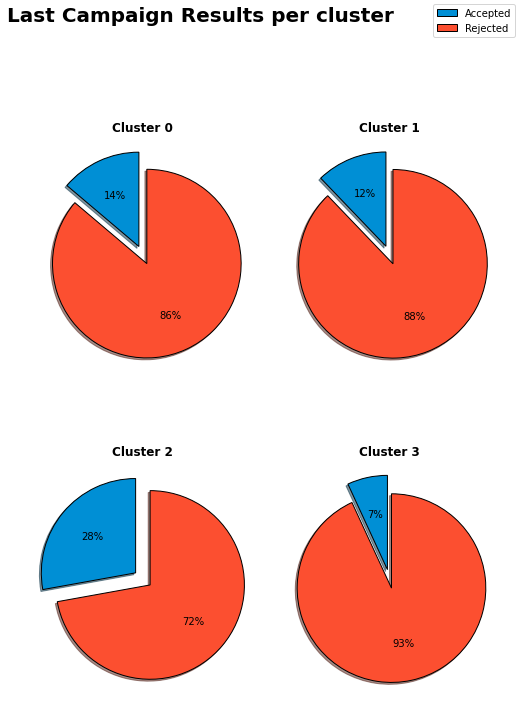

In [182]:
create_campaign_pie_charts(dfk, 'Response', 'Last Campaign Results per cluster')

Well that's a good sign, apparently on cluster 2 we have  a success rate of 28% on the last campaign. An increase from 15% to 28% seems great. 

Now lets try to understand a bit more about that Cluster 2. How are those customers different from the other ones?.

Starting with some box plots on numerical variables.

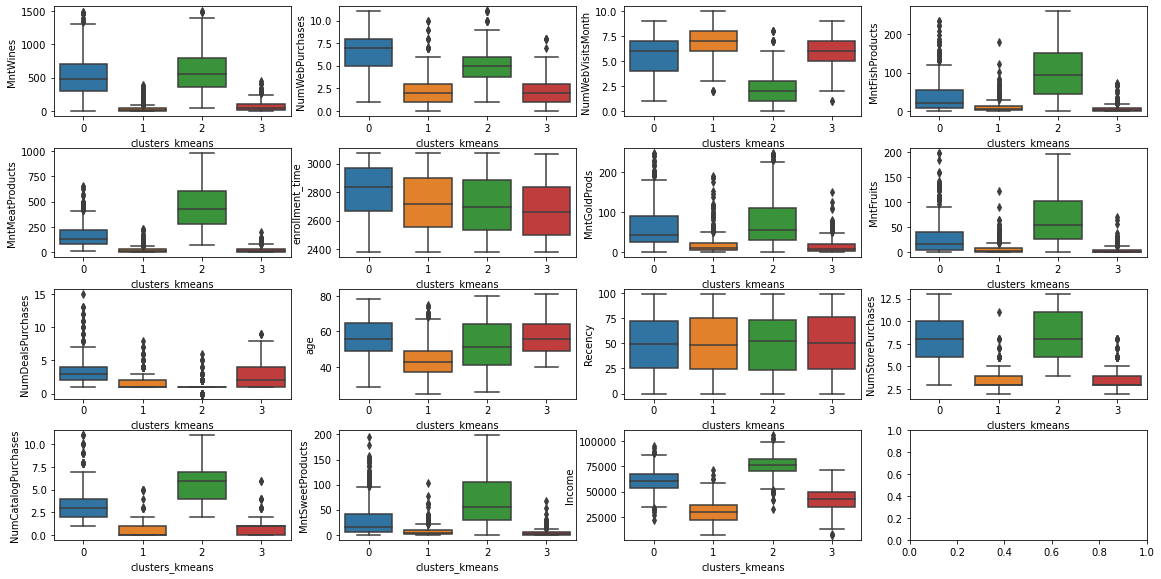

In [69]:
plot_boxes(df2, 'clusters_kmeans', 4, 4, list(set(numerical_cols)-set(['Kidhome','Teenhome'])))

- Amount spent on Wine: Cluster 0 and 2 spend more money on wine compared to the rest of the customers. Still Cluster 2 is the group that spends the most.


- Amount spent on Meats: Cluster 2 is the group that spends the most on meat.


- Number of deals purchases: Cluster 2 buys the least amount of deals.


- Number of catalog purchases: Cluster 2 has the most amount of catalog purchases.


- Number of web purchases: Cluster 0 has the most amount of web purchases, while clusters 1 and 3 have the lowest. Cluster 2 is located in the middle for this variable.


- Enrollment time: Seems to be pretty similar between all 4 groups.


- Age: Cluster 2 has the biggest upper and lower quartiles, taking into account a lot of customers between 40 and 70 years old.


- Amount spent on sweets: Cluster 2 in the group that spends the most in sweets.


- Number of web visits: Cluster 2 has the least amount of web visits per month.


- Amount spent on gold: Clusters 0 and 2 have the most amount spent on gold.


- Recency: Seems to be similar between all 4 groups.


- Income: Cluster 2 has the highest income customers.


- Amount spent on fish products: Cluster 2 have the most amount spent on fish products.


- Amount spent on fruits: Cluster 2 have the most amount spent on fruits.


- Number of store purchases: Clusters 0 and 2 have the most amount of store purchases.

Now lets check the categorical variables of our clusters, maybe we can find some extra information too

In [141]:
def join_append(dict1, dict2):
    """function that joins 2 dictionaries by appending 2nd's information to the first
    """
    for key in dict1.keys():
        try:
            dict1[key].append(dict2[key])
        except KeyError:
            dict1[key].append(0)
            
def get_categorical_frequency_cluster(df, group, variable, k):
    """function that returns a Pandas DataFrame of the frequencies of the specified
    variable per cluster
    """
    kmeans_list = {}
    for camp in df2[variable].unique(): kmeans_list[camp] = []
        
    for clust in range(0, k):   
        for camp in [variable]:
            freq = df[df[group] == clust][camp].value_counts()
            freq2 = {k: v / df[df[group] == clust].shape[0] for k, v in freq.items()}
            join_append(kmeans_list, freq2)
        
    return pd.DataFrame(kmeans_list, index=range(0, k))

In [197]:
get_categorical_frequency_cluster(df2, 'clusters_kmeans', 'Education', 4)

,Graduation,PhD,Master,Basic,2n Cycle
0,0.480000,0.289091,0.167273,0.003636,0.060000
1,0.510274,0.133562,0.152397,0.080479,0.123288
2,0.558712,0.196970,0.149621,0.000000,0.094697
3,0.472275,0.242830,0.193117,0.009560,0.082218


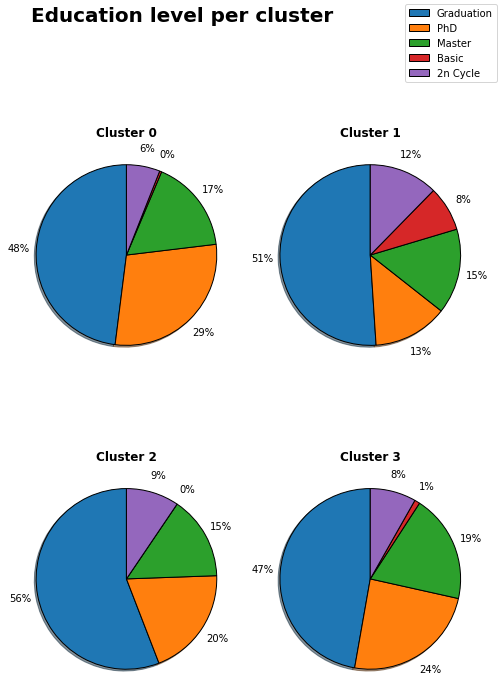

In [198]:
create_categorical_pie_charts(get_categorical_frequency_cluster(df2, 'clusters_kmeans', 'Education', 4), 'Education level per cluster')

All 4 pie charts have a pretty similar appereance, we could think about cluster 0 and 2 having a really low of basic education. Letting us think that customers with basic education may tend to reject the last campaign. 

What about the Marital Status??

In [145]:
get_categorical_frequency_cluster(df2, 'clusters_kmeans', 'Marital_Status', 4)

,Single,Together,Married,Divorced,Widow
0,0.161818,0.260000,0.405455,0.123636,0.049091
1,0.253425,0.243151,0.412671,0.080479,0.010274
2,0.250000,0.251894,0.361742,0.096591,0.039773
3,0.183556,0.282983,0.372849,0.118547,0.042065


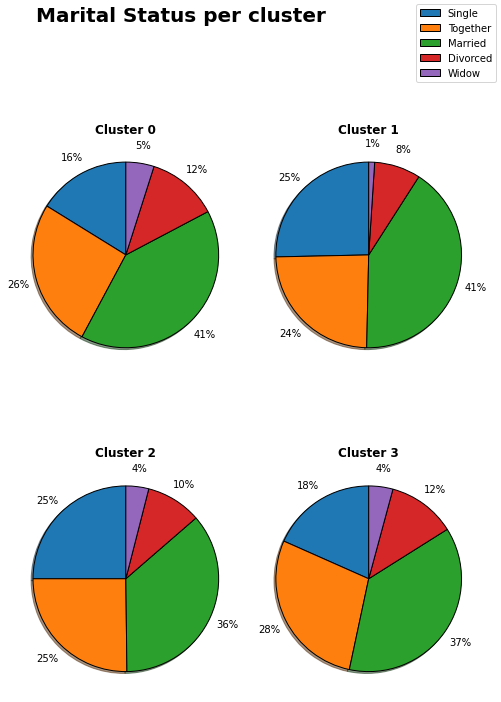

In [200]:
create_categorical_pie_charts(get_categorical_frequency_cluster(df2, 'clusters_kmeans', 'Marital_Status', 4), 'Marital Status per cluster')

On the previous notebook (Data Analysis) we thought single customers tend to accept more the last campaign, but apparently that is not really important for the actual cluster creation. Other than that, probably marital status is not too important for segmenting our customers into this 4 groups.

### Conclusions about Cluster 2
Cluster 2 customers are the ones with the highest income, according to that they are also the ones that spend the most on every product. They prefer to shop in the actual stores or catalogs instead of visiting the webpage, but the still are in the middle of the pack for web purchases. It is like they usually don't visit the website, but when they do then they buy. Finally, Age is not a really defining variable of this cluster, we can find customers from all ages.

On the other hand, cluster 0 has some similarities with cluster 2 with them also being the groups with the second highest success rate on last campaign. They also like to spend on wine, but unlike cluster 2, they visit the website a lot more frequently and buy there more too.